In [5]:
%matplotlib inline
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [6]:
# Parameters
test_images = [ f.path for f in os.scandir("../test_images/")]
image_dict = "../camera_properties.pkl"

In [7]:
# Load camera properties
with open(image_dict, "rb") as fd:
    camera_properties = pickle.load(fd)

In [8]:
camera_properties.keys()

dict_keys(['mtx', 'dist'])

In [9]:
mtx = camera_properties['mtx']
dist = camera_properties['dist']

In [10]:
img_np = cv2.imread(test_images[0])

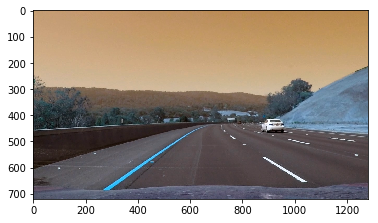

In [11]:
plt.imshow(img_np)

In [12]:
def get_perspective_transform(image, src_in = None, dst_in = None, display=False):
    img_size = image.shape
    if src_in is None:
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        src = src_in

    if dst_in is None:
        dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    else:
        dst = dst_in

    warp_m = cv2.getPerspectiveTransform(src, dst)
    warp_minv = cv2.getPerspectiveTransform(dst, src)

    if display:
        plt.subplot(1,2,1)

        plt.imshow(image, cmap='gray')
        colors = ['r+','g+','b+','w+']
        for i in range(4):
            plt.plot(src[i,0],src[i,1],colors[i])

        im2 = cv2.warpPerspective(image, warp_m, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        plt.subplot(1,2,2)

        plt.imshow(im2, cmap='gray')
        for i in range(4):
            plt.plot(dst[i,0],dst[i,1],colors[i])
        plt.show()
    return warp_m, warp_minv

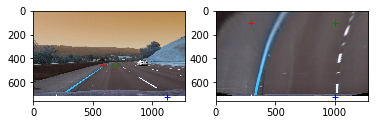

<Figure size 432x288 with 0 Axes>

In [13]:
_, _ = get_perspective_transform(img_np, display=True)
plt.savefig("../output_images/perspective.png")

In [14]:
def find_perspective_points(image):
    edges = find_edges(image)

    # Computing perspective points automatically
    rho = 2              # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180  # angular resolution in radians of the Hough grid
    threshold = 100       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 # minimum number of pixels making up a line
    max_line_gap = 25    # maximum gap in pixels between connectable line segments

    angle_min_mag = 20*pi/180
    angle_max_mag = 65*pi/180

    lane_markers_x = [[], []]
    lane_markers_y = [[], []]

    masked_edges = np.copy(edges)
    masked_edges[:edges.shape[0]*6//10,:] = 0
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = atan2(y1-y2, x2-x1)
            rho = ((x1+x2)*cos(theta) + (y1+y2)*sin(theta))/2
            if (abs(theta) >= angle_min_mag and abs(theta) <= angle_max_mag):
                if theta > 0: # positive theta is downward in image space?
                    i = 0 # Left lane marker
                else:
                    i = 1 # Right lane marker
                lane_markers_x[i].append(x1)
                lane_markers_x[i].append(x2)
                lane_markers_y[i].append(y1)
                lane_markers_y[i].append(y2)

    if len(lane_markers_x[0]) < 1 or len(lane_markers_x[1]) < 1:
        # Failed to find two lane markers
        return None

    p_left  = np.polyfit(lane_markers_y[0], lane_markers_x[0], 1)
    p_right = np.polyfit(lane_markers_y[1], lane_markers_x[1], 1)

    # Find intersection of the two lines
    apex_pt = np.linalg.solve([[p_left[0], -1], [p_right[0], -1]], [-p_left[1], -p_right[1]])
    top_y = ceil(apex_pt[0] + 0.075*edges.shape[0])

    bl_pt = ceil(np.polyval(p_left, edges.shape[0]))
    tl_pt = ceil(np.polyval(p_left, top_y))

    br_pt = ceil(np.polyval(p_right, edges.shape[0]))
    tr_pt = ceil(np.polyval(p_right, top_y))

    src = np.array([[tl_pt, top_y],
                    [tr_pt, top_y],
                    [br_pt, edges.shape[0]],
                    [bl_pt, edges.shape[0]]], np.float32)

    get_perspective_transform(edges, src_in = src, dst_in = None, display=False)
    return src